In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


DalbergiaLatifolia: 22 samples
DalbergiaMadagascariensis: 20 samples
DalbergiaMelanoxylon: 19 samples
DalbergiaNigra: 19 samples
DalbergiaRetusaCF: 18 samples
DalbergiaSpruceana: 20 samples


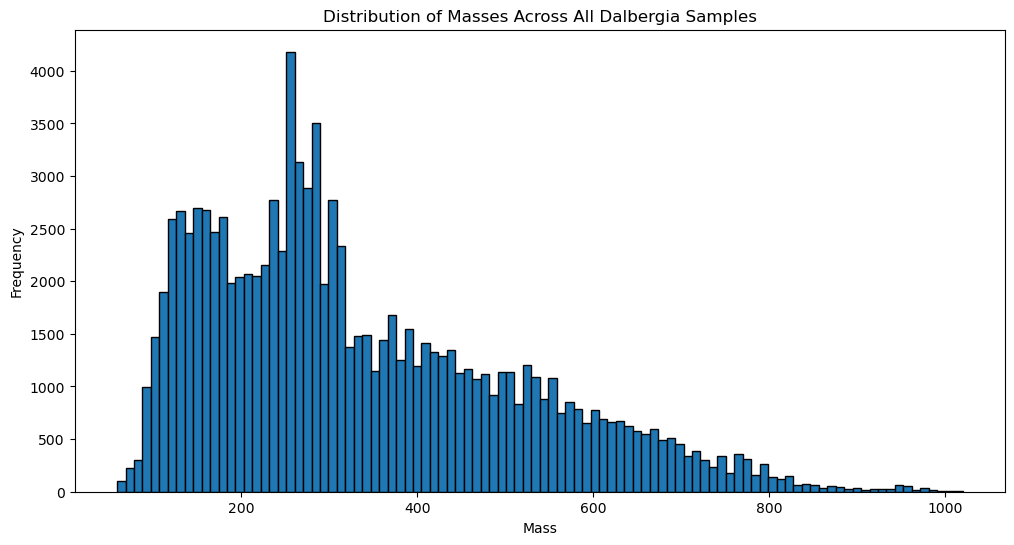

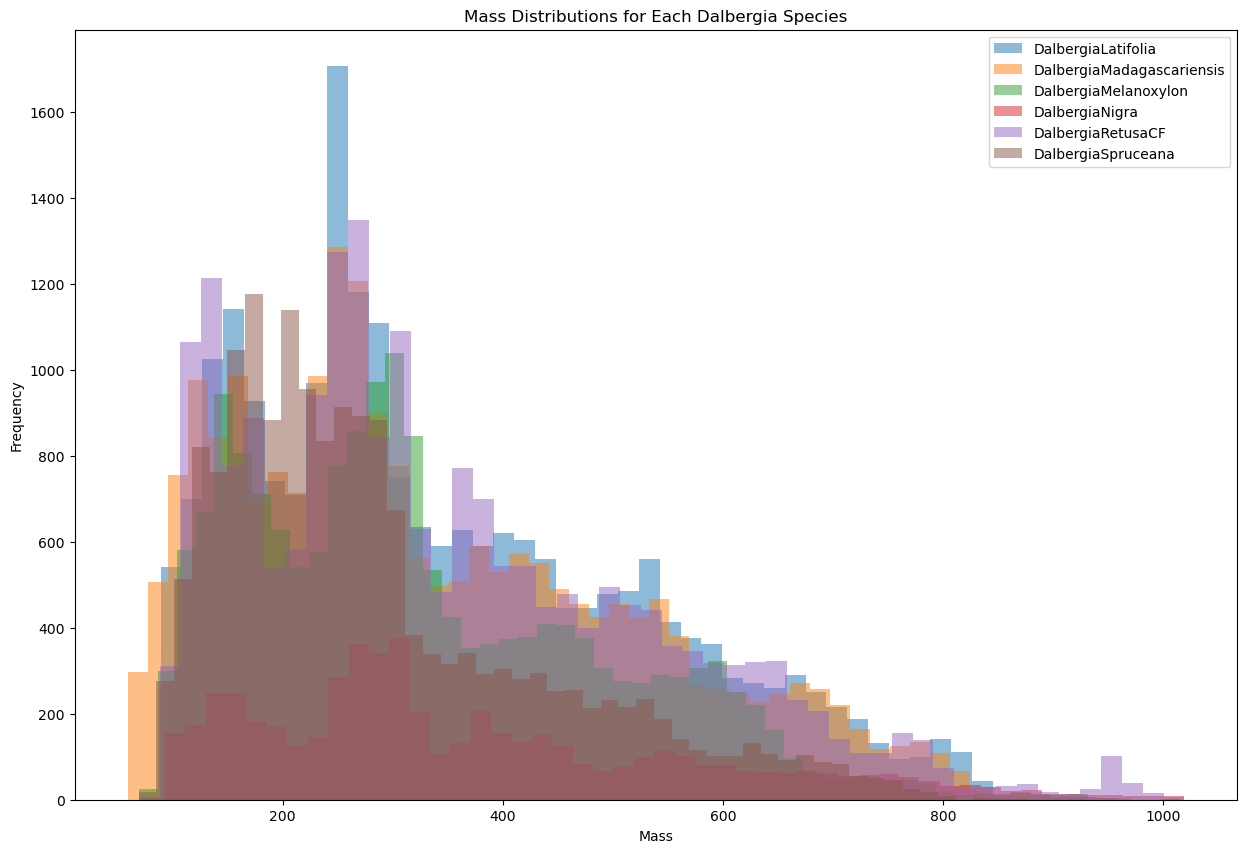

In [9]:
import os
import numpy as np
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt


def load_dalbergia_mass_data_for_vae(main_folder):
    all_masses = []
    all_labels = []
    species_to_label = {}
    label_to_species = {}

    for i, species_folder in enumerate(sorted(os.listdir(main_folder))):
        if not species_folder.startswith('Dalbergia'):
            continue
        
        species_path = os.path.join(main_folder, species_folder)
        
        if os.path.isdir(species_path):
            label = i - 1  # Shift labels down by 1 to start from 0
            species_to_label[species_folder] = label
            label_to_species[label] = species_folder
            file_paths = [os.path.join(species_path, f) for f in os.listdir(species_path) if f.endswith('.txt')]
            
            for file_path in file_paths:
                try:
                    data = pd.read_csv(file_path, sep='\t', header=1)
                    mass_values = data.iloc[:, 0].values  # Assuming mass is the first column
                    all_masses.append(mass_values)
                    all_labels.append(label)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    # Convert to tensors and pad
    tensor_masses = [torch.tensor(masses, dtype=torch.float32) for masses in all_masses]
    padded_masses = pad_sequence(tensor_masses, batch_first=True, padding_value=0.0)

    # Create mask
    mask = torch.ones_like(padded_masses, dtype=torch.bool)
    for i, masses in enumerate(tensor_masses):
        mask[i, len(masses):] = False

    # Convert labels to tensor
    labels = torch.tensor(all_labels, dtype=torch.long)

    # print(f"Label range: {labels.min().item()} to {labels.max().item()}")
    # print(f"Unique labels: {torch.unique(labels)}")
    # print(f"Species to label mapping: {species_to_label}")
    # print(f"Label to species mapping: {label_to_species}")
    # print(f"Label distribution: {torch.bincount(labels)}")

    return padded_masses, labels, mask, species_to_label

# Usage
main_folder = r"C:\Users\Marshall\TEST DATA\TEST DATA"
masses, labels, mask, species_mapping = load_dalbergia_mass_data_for_vae(main_folder)

# Print summary
# print("Masses shape:", masses.shape)
# print("Labels shape:", labels.shape)
# print("Mask shape:", mask.shape)
# print("Species mapping:", species_mapping)

# Print sample counts for each species
unique, counts = np.unique(labels.numpy(), return_counts=True)
for label, count in zip(unique, counts):
    species = [k for k, v in species_mapping.items() if v == label][0]
    print(f"{species}: {count} samples")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masses = masses.to(device)
labels = labels.to(device)
mask = mask.to(device)

# Basic statistics of the mass data
# print("Mass range:", masses[mask].min().item(), "to", masses[mask].max().item())
# print("Mean mass:", masses[mask].mean().item())
# print("Median mass:", masses[mask].median().item())

# Histogram of all masses (using CPU for numpy compatibility)
all_masses = masses[mask].cpu().numpy()
plt.figure(figsize=(12, 6))
plt.hist(all_masses, bins=100, edgecolor='black')
plt.title("Distribution of Masses Across All Dalbergia Samples")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.show()

# Histograms for each Dalbergia species
plt.figure(figsize=(15, 10))
for label in unique:
    species_name = [k for k, v in species_mapping.items() if v == label][0]
    species_masses = masses[labels == label][mask[labels == label]].cpu().numpy()
    plt.hist(species_masses, bins=50, alpha=0.5, label=species_name)

plt.title("Mass Distributions for Each Dalbergia Species")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example of how to use this data with a VAE for mass distribution modeling
# You'll need to implement a VAE that takes masses as input and generates synthetic masses
# vae = DalbergiaMassDistributionVAE(...)

# Training loop example
# optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
# for epoch in range(num_epochs):
#     for i in range(0, len(masses), batch_size):
#         batch_masses = masses[i:i+batch_size]
#         batch_labels = labels[i:i+batch_size]
#         batch_mask = mask[i:i+batch_size]
#         
#         optimizer.zero_grad()
#         recon_masses, mu, log_var = vae(batch_masses, batch_labels, mask=batch_mask)
#         
#         # Compute loss (you'll need to implement this based on your specific requirements)
#         loss = compute_loss(recon_masses, batch_masses, mu, log_var, batch_mask)
#         
#         loss.backward()
#         optimizer.step()

# Generate synthetic masses for a specific Dalbergia species
# with torch.no_grad():
#     species_label = torch.tensor([0]).to(device)  # Adjust based on which Dalbergia species you want to generate
#     synthetic_masses = vae.generate(num_samples=10, seq_len=masses.size(1), species_labels=species_label)

In [10]:
class MassNormalizer:
    def __init__(self, masses, mask):
        self.min_mass = masses[mask].min().item()
        self.max_mass = masses[mask].max().item()
        self.range = self.max_mass - self.min_mass

    def normalize(self, masses):
        return (masses - self.min_mass) / self.range

    def denormalize(self, normalized_masses):
        return normalized_masses * self.range + self.min_mass

In [11]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence

class GMMLayer(nn.Module):
    def __init__(self, input_dim, num_components):
        super(GMMLayer, self).__init__()
        self.input_dim = input_dim
        self.num_components = num_components
        
        self.mixing_logits = nn.Linear(input_dim, num_components)
        self.means = nn.Linear(input_dim, num_components)
        self.log_vars = nn.Linear(input_dim, num_components)
    
    def forward(self, x):
        mixing_logits = self.mixing_logits(x)
        means = self.means(x)
        log_vars = self.log_vars(x)
        return mixing_logits, means, log_vars
    
class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False):
        super(ResidualLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.residual = nn.Linear(input_size, hidden_size * (2 if bidirectional else 1))
        self.bidirectional = bidirectional

    def forward(self, x):
        if isinstance(x, PackedSequence):
            lstm_out, (h, c) = self.lstm(x)
            residual_input = x.data
            residual = self.residual(residual_input)
            if self.bidirectional:
                residual = residual.view(residual.size(0), 2, -1).transpose(0, 1).contiguous().view(-1, residual.size(-1))
            lstm_out_data = lstm_out.data + residual
            return PackedSequence(lstm_out_data, lstm_out.batch_sizes, lstm_out.sorted_indices, lstm_out.unsorted_indices), (h, c)
        else:
            residual = self.residual(x)
            lstm_out, (h, c) = self.lstm(x)
            if self.bidirectional:
                residual = residual.view(residual.size(0), residual.size(1), 2, -1).transpose(1, 2).contiguous().view(residual.size(0), residual.size(1), -1)
            return lstm_out + residual, (h, c)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DalbergiaMassVAE(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_layers, dropout_rate, num_species, num_components, min_mass, max_mass):
        super(DalbergiaMassVAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.num_species = num_species
        self.num_components = num_components
        self.min_mass = min_mass
        self.max_mass = max_mass

        self.species_embedding = nn.Embedding(num_species, hidden_dim)
        self.encoder_rnn = nn.ModuleList([
            ResidualLSTM(1 + hidden_dim if i == 0 else hidden_dim * 2, hidden_dim, bidirectional=True)
            for i in range(num_layers)
        ])
        self.encoder_fc = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.log_var = nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim + hidden_dim, hidden_dim)
        self.decoder_rnn = nn.ModuleList([
            ResidualLSTM(hidden_dim, hidden_dim)
            for _ in range(num_layers)
        ])
        self.gmm_layer = GMMLayer(hidden_dim, num_components)
        self.dropout = nn.Dropout(dropout_rate)
        

    def encode(self, x, species_labels, mask):
        species_emb = self.species_embedding(species_labels).unsqueeze(1).expand(-1, x.size(1), -1)
        encoder_input = torch.cat([x.unsqueeze(-1), species_emb], dim=-1)
        encoder_input = encoder_input * mask.unsqueeze(-1)
        
        packed_input = nn.utils.rnn.pack_padded_sequence(encoder_input, mask.sum(1).cpu(), batch_first=True, enforce_sorted=False)
        
        for layer in self.encoder_rnn:
            packed_output, _ = layer(packed_input)
            packed_input = packed_output
        
        encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1))
        
        h_n = encoder_outputs[:, -1, :]
        h_n = self.dropout(h_n)
        h_n = F.relu(self.encoder_fc(h_n))
        
        return self.mu(h_n), self.log_var(h_n)      
        

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, species_labels, seq_len):
        species_emb = self.species_embedding(species_labels)
        decoder_input = torch.cat([z, species_emb], dim=-1)
        decoder_input = F.relu(self.decoder_fc(decoder_input))
        decoder_input = decoder_input.unsqueeze(1).repeat(1, seq_len, 1)
        
        outputs = decoder_input
        for layer in self.decoder_rnn:
            outputs, _ = layer(outputs)
        
        outputs = self.dropout(outputs)
        
        mixing_logits, means, log_vars = self.gmm_layer(outputs)
        
        # Scale means to the original mass range
        means = self.min_mass + F.sigmoid(means) * (self.max_mass - self.min_mass)
        
        return mixing_logits, means, log_vars

    def forward(self, x, species_labels, mask):
        mu, log_var = self.encode(x, species_labels, mask)
        z = self.reparameterize(mu, log_var)
        mixing_logits, means, log_vars = self.decode(z, species_labels, x.size(1))
        return mixing_logits, means, log_vars, mu, log_var
        
    def generate(self, num_samples, seq_len, species_labels):
        z = torch.randn(num_samples, self.latent_dim, device=species_labels.device)
        return self.decode(z, species_labels, seq_len)
    
    

c:\ProgramData\anaconda3\envs\pt_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/1000], Loss: 13198.4909, Recon Loss: 13187.9561, KL Loss: 10.5348
Epoch [2/1000], Loss: 1701.9331, Recon Loss: 482.9647, KL Loss: 1218.9683
Epoch [3/1000], Loss: 132.4337, Recon Loss: 106.2353, KL Loss: 26.1984
Epoch [4/1000], Loss: 3696.2537, Recon Loss: 9.2149, KL Loss: 3687.0390
Epoch [5/1000], Loss: 47.3427, Recon Loss: 8.7028, KL Loss: 38.6398
Epoch [6/1000], Loss: 66.9660, Recon Loss: 8.3356, KL Loss: 58.6304
Epoch [7/1000], Loss: 50.5949, Recon Loss: 7.2379, KL Loss: 43.3570
Epoch [8/1000], Loss: 13.1015, Recon Loss: 7.0775, KL Loss: 6.0240
Epoch [9/1000], Loss: 12.2318, Recon Loss: 6.9723, KL Loss: 5.2596
Epoch [10/1000], Loss: 11.3266, Recon Loss: 6.8863, KL Loss: 4.4404
Epoch [11/1000], Loss: 9.0451, Recon Loss: 6.8178, KL Loss: 2.2273
Epoch [12/1000], Loss: 7.3836, Recon Loss: 6.7530, KL Loss: 0.6307
Epoch [13/1000], Loss: 6.9790, Recon Loss: 6.7196, KL Loss: 0.2595
Epoch [14/1000], Loss: 68.5795, Recon Loss: 6.7725, KL Loss: 61.8070
Epoch [15/1000], Loss: 9.0016, R

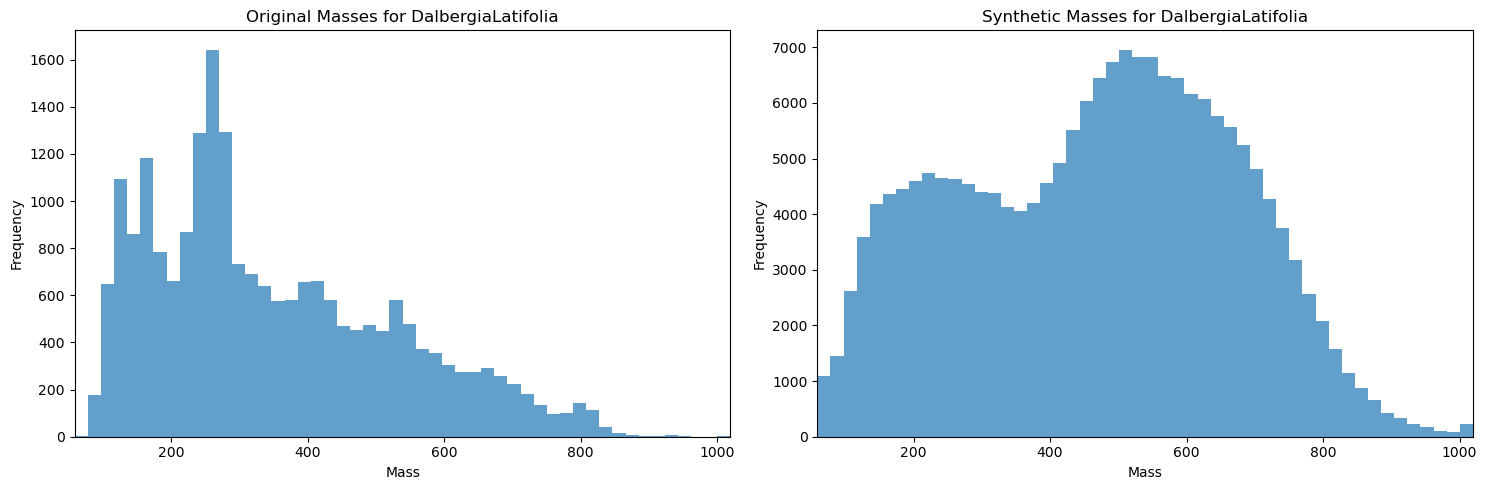

Statistics for DalbergiaLatifolia:
Original - Min: 70.06, Max: 1015.34, Mean: 348.94, Std: 178.32
Synthetic - Min: 59.04, Max: 1019.37, Mean: 467.37, Std: 200.88


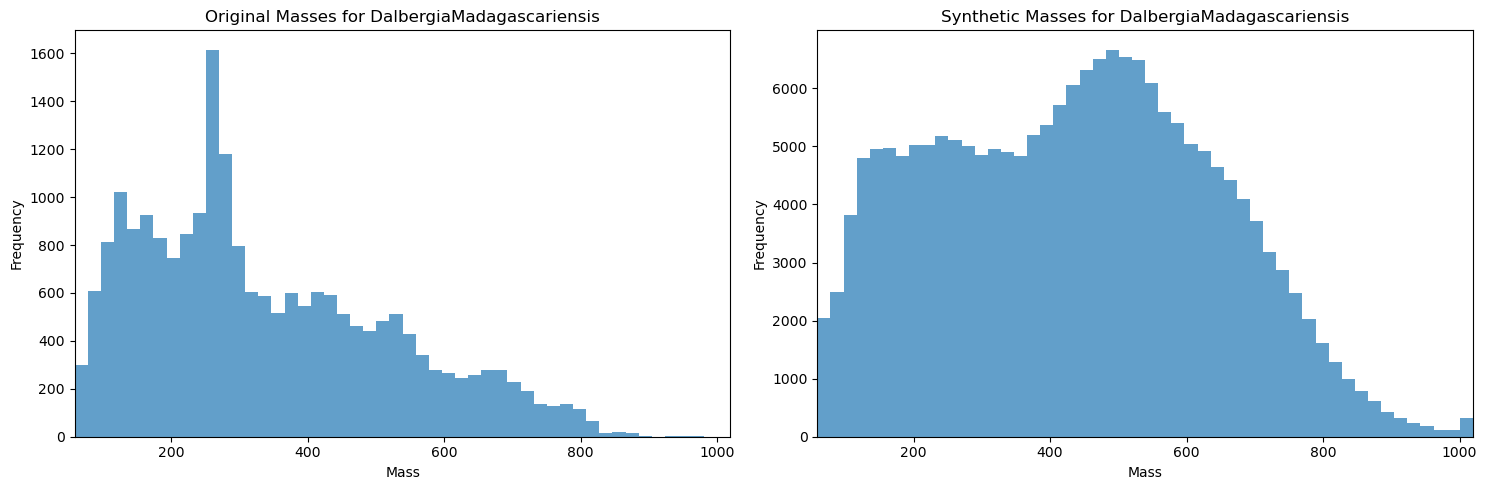

Statistics for DalbergiaMadagascariensis:
Original - Min: 59.04, Max: 970.66, Mean: 338.21, Std: 182.93
Synthetic - Min: 59.04, Max: 1019.37, Mean: 435.81, Std: 202.72


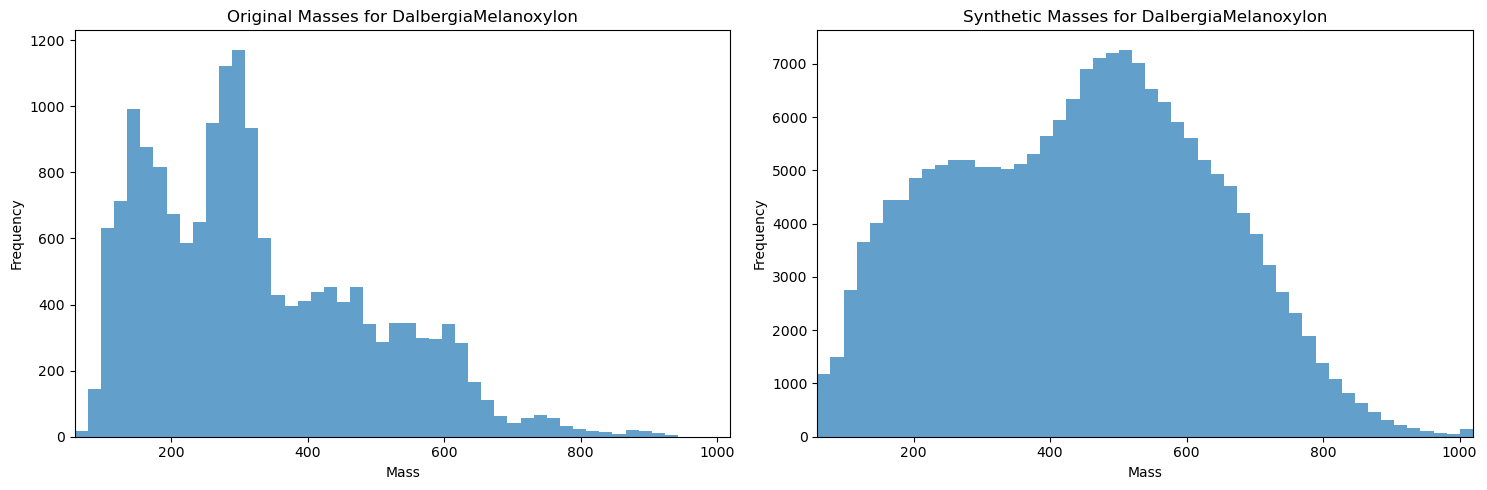

Statistics for DalbergiaMelanoxylon:
Original - Min: 69.00, Max: 931.29, Mean: 328.09, Std: 162.22
Synthetic - Min: 59.04, Max: 1019.37, Mean: 444.66, Std: 191.00


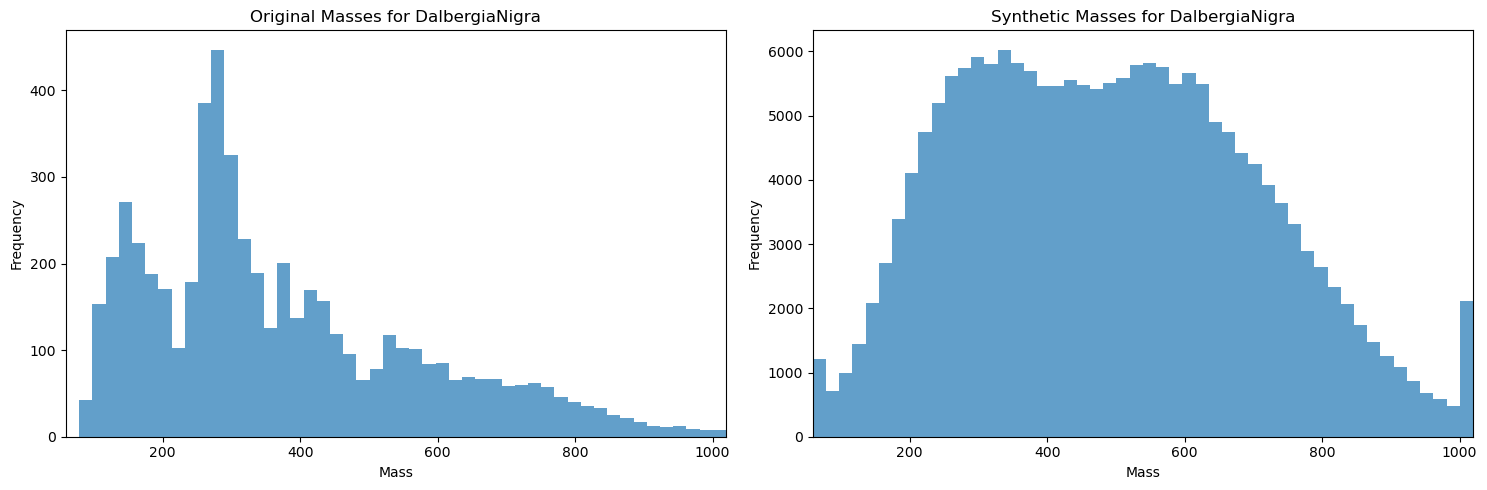

Statistics for DalbergiaNigra:
Original - Min: 93.06, Max: 1019.31, Mean: 373.12, Std: 199.28
Synthetic - Min: 59.04, Max: 1019.37, Mean: 491.00, Std: 211.78


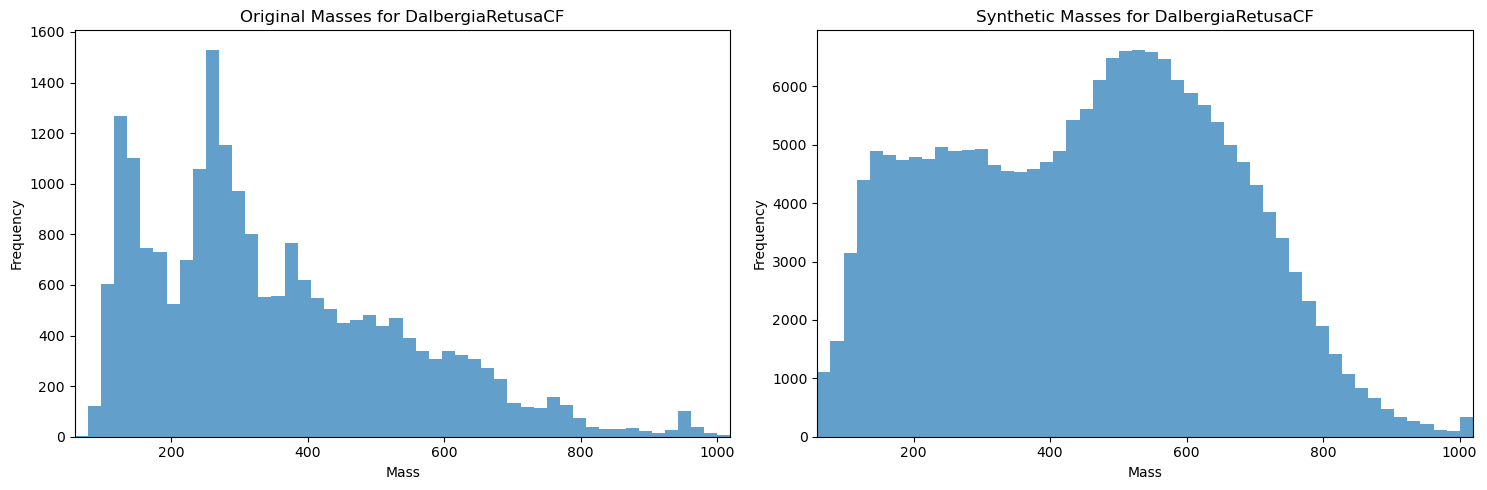

Statistics for DalbergiaRetusaCF:
Original - Min: 69.03, Max: 1019.37, Mean: 353.22, Std: 185.69
Synthetic - Min: 59.04, Max: 1019.37, Mean: 454.03, Std: 203.33


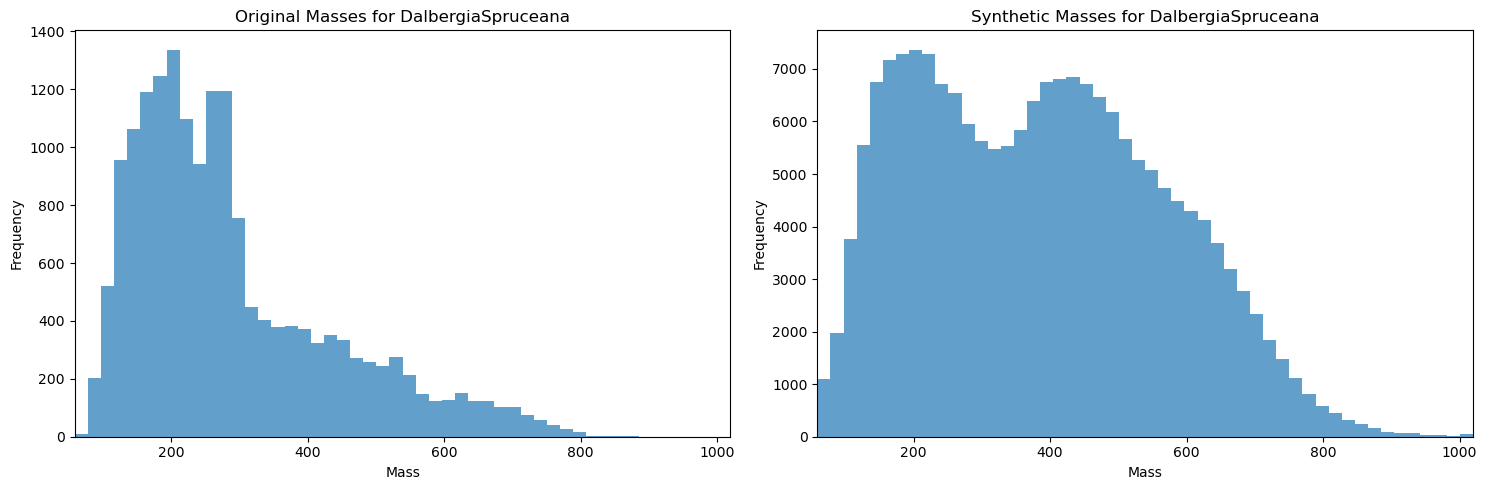

Statistics for DalbergiaSpruceana:
Original - Min: 69.03, Max: 876.33, Mean: 289.31, Std: 149.41
Synthetic - Min: 59.04, Max: 1019.37, Mean: 386.27, Std: 181.26
Mass generation and visualization complete for all Dalbergia species.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt


def gmm_loss(mixing_logits, means, log_vars, x, mask):
    vars = torch.exp(torch.clamp(log_vars, min=-20, max=20))  # Clamp log_vars to prevent extreme values
    eps = 1e-8
    component_log_probs = torch.distributions.Normal(means, torch.sqrt(vars + eps)).log_prob(x.unsqueeze(-1))
    log_mixing = F.log_softmax(mixing_logits, dim=-1)
    log_prob = torch.logsumexp(log_mixing + component_log_probs, dim=-1)
    
    loss = -log_prob
    loss = torch.clamp(loss, min=0.0, max=1e6)  # Clamp loss to prevent extreme values
    
    masked_loss = (loss * mask).sum() / (mask.sum() + eps)
    
    return masked_loss

def compute_loss(mixing_logits, means, log_vars, x, mask, mu, log_var):
    recon_loss = gmm_loss(mixing_logits, means, log_vars, x, mask)
    
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = kl_loss / x.size(0)
    
    return recon_loss + kl_loss

def train_dalbergia_vae(model, masses, labels, mask, num_epochs, batch_size, learning_rate, clip_value=1.0, device=torch.device('cpu')):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        num_batches = 0
        
        indices = torch.randperm(len(masses))
        
        for i in range(0, len(masses), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_masses = masses[batch_indices].to(device)
            batch_labels = labels[batch_indices].to(device)
            batch_mask = mask[batch_indices].to(device)

            optimizer.zero_grad()
            
            try:
                mixing_logits, means, log_vars, mu, log_var = model(batch_masses, batch_labels, batch_mask)
                
                recon_loss = gmm_loss(mixing_logits, means, log_vars, batch_masses, batch_mask)
                
                kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                kl_loss = kl_loss / batch_masses.size(0)
                
                loss = recon_loss + kl_loss
                
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                
                optimizer.step()
                
                total_loss += loss.item()
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()
                num_batches += 1
                
            except Exception as e:
                print(f"Error during training: {e}")
                print(f"batch_masses shape: {batch_masses.shape}, batch_labels shape: {batch_labels.shape}, batch_mask shape: {batch_mask.shape}")
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f"{name} - grad shape: {param.grad.shape}, grad min: {param.grad.min()}, grad max: {param.grad.max()}")
                    else:
                        print(f"{name} - No grad")
                raise e
        
        avg_loss = total_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        avg_kl_loss = total_kl_loss / num_batches
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")

        # Step the scheduler
        scheduler.step(avg_loss)

    return model

def generate_synthetic_masses(model, num_samples, seq_len, species_labels, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim, device=device)
        synthetic_masses = model.decode(z, species_labels, seq_len)
    return synthetic_masses

def visualize_masses(original_masses, synthetic_masses, species_name):
    plt.figure(figsize=(15, 5))

    # Determine common min and max for both plots
    overall_min = min(original_masses.min(), synthetic_masses.min())
    overall_max = max(original_masses.max(), synthetic_masses.max())

    # Original masses
    plt.subplot(1, 2, 1)
    plt.hist(original_masses.flatten(), bins=100, range=(overall_min, overall_max), alpha=0.7, label='Original')
    plt.title(f"Original Masses for {species_name}")
    plt.xlabel("Mass")
    plt.ylabel("Frequency")
    plt.xlim(overall_min, overall_max)

    # Synthetic masses
    plt.subplot(1, 2, 2)
    plt.hist(synthetic_masses.flatten(), bins=100, range=(overall_min, overall_max), alpha=0.7, label='Synthetic')
    plt.title(f"Synthetic Masses for {species_name}")
    plt.xlabel("Mass")
    plt.ylabel("Frequency")
    plt.xlim(overall_min, overall_max)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Statistics for {species_name}:")
    print(f"Original - Min: {original_masses.min():.2f}, Max: {original_masses.max():.2f}, Mean: {original_masses.mean():.2f}, Std: {original_masses.std():.2f}")
    print(f"Synthetic - Min: {synthetic_masses.min():.2f}, Max: {synthetic_masses.max():.2f}, Mean: {synthetic_masses.mean():.2f}, Std: {synthetic_masses.std():.2f}")


# Main execution
if __name__ == "__main__":
    # Load data
    main_folder = r"C:\Users\Marshall\TEST DATA\TEST DATA"
    masses, labels, mask, species_mapping = load_dalbergia_mass_data_for_vae(main_folder)

    #visualize_mask(mask[:10], "Mask for first 10 samples of the dataset")
    # print(f"Loaded data shapes - masses: {masses.shape}, labels: {labels.shape}, mask: {mask.shape}")
    # print(f"Number of species: {len(species_mapping)}")
    # print(f"Species mapping: {species_mapping}")
    # print(f"Label counts: {torch.bincount(labels)}")
    # print(f"Mass range: {masses.min().item()} to {masses.max().item()}")

   

    # Model parameters
    latent_dim = 64
    hidden_dim = 128
    num_layers = 3
    dropout_rate = 0.2
    num_species = len(species_mapping)

    # Training parameters
    num_epochs = 1000
    batch_size = 32
    learning_rate = 0.001
    num_components = 8

    # Get min and max mass values
    min_mass = masses[mask].min().item()
    max_mass = masses[mask].max().item()

     # Initialize the model
    model = DalbergiaMassVAE(latent_dim, hidden_dim, num_layers, dropout_rate, num_species, num_components, min_mass, max_mass).to(device)
    # # Print model summary
    # print(model)
    # print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

    # # Print first few labels to verify
    # print(f"First 20 labels: {labels[:20]}")
    masses = masses.to(device)
    labels = labels.to(device)
    mask = mask.to(device)
    try:
        # Train the model
        trained_model = train_dalbergia_vae(model, masses, labels, mask, num_epochs, batch_size, learning_rate, device=device)
        trained_model = trained_model.to(device)
        # Generate and visualize synthetic masses for each species
        # Generate and visualize synthetic masses for each species
        # Generate and visualize synthetic masses for each species
        for species_name, species_idx in species_mapping.items():
            num_samples = 100
            seq_len = masses.shape[1]
            species_label = torch.tensor([species_idx], device=device).repeat(num_samples)
            z = torch.randn(num_samples, latent_dim, device=device)
            mixing_logits, means, log_vars = trained_model.decode(z, species_label, seq_len)
    
            # Sample from the GMM
            component_distribution = torch.distributions.Categorical(logits=mixing_logits)
            component_samples = component_distribution.sample()
    
            selected_means = means.gather(-1, component_samples.unsqueeze(-1)).squeeze(-1)
            selected_vars = torch.exp(log_vars.gather(-1, component_samples.unsqueeze(-1)).squeeze(-1))
    
            normal_distribution = torch.distributions.Normal(selected_means, torch.sqrt(selected_vars))
            synthetic_masses = normal_distribution.sample()

            # Ensure synthetic masses are within the original range
            synthetic_masses = torch.clamp(synthetic_masses, min=min_mass, max=max_mass)

            # Select original masses and corresponding mask for this species
            species_mask = mask[labels == species_idx]
            original_masses = masses[labels == species_idx]

            # Apply the mask to remove padded values
            original_masses_masked = original_masses[species_mask]

            visualize_masses(original_masses_masked.cpu().numpy(), 
                     synthetic_masses.cpu().detach().numpy(), 
                     species_name)

        print("Mass generation and visualization complete for all Dalbergia species.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()